## 通过梯度加一个参考值复原灰度图像

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.sparse as sparse

In [2]:
# 读取图像并将其更改为灰度图像
i01 = cv2.imread('warmup_image.png')
i01g = cv2.cvtColor(i01, cv2.COLOR_BGR2GRAY)

# 为图像创建2d索引
[h,w] = i01g.shape
im2ind = np.reshape(np.arange(0,h*w), [h,w])
b = np.zeros(h*w)

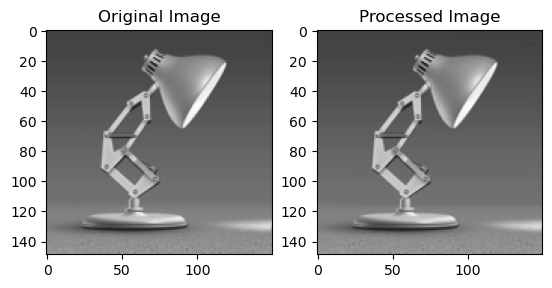

In [3]:
# 初始化A和b(用于Av-b的最小二乘)
A = sparse.lil_matrix((h*w*2-300+2, h*w))
b = np.zeros((h*w*2-300+2))
e = 0

# 计算两个水平像素的差值
for i in range(h):
    for j in range(w-1):
        A[e,im2ind[i,j]] = 1
        A[e,im2ind[i,j+1]] = -1
        b[e] = int(i01g[i,j]) - int(i01g[i,j+1]) # 将uint8转换为int以支持负数
        e = e+1

# 计算两个垂直像素的差值
for i in range(h-1):
    for j in range(w):
        A[e,im2ind[i,j]] = 1
        A[e,im2ind[i+1,j]] = -1
        b[e] = int(i01g[i,j]) - int(i01g[i+1,j])
        e = e+1

# 设置约束(一个已知的像素值作为参考值)
A[e,im2ind[0,0]] = 1
b[e]=i01g[0,0]

# 求v的线性最小二乘
v = sparse.linalg.lsqr(A, b)

# 重建图像
result = np.reshape(v[0], (h, w))

plt.subplot(1, 2, 1)
plt.imshow(i01g, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(result, cmap='gray')
plt.title('Processed Image')

plt.show()

## 直接用蒙版混合图像

In [4]:
# 导入图像和蒙版
front = cv2.imread('front.jpg')
back = cv2.imread('background.jpg')
mask = cv2.imread('mask0.jpg', cv2.IMREAD_GRAYSCALE)

# 将正面图像及其蒙版裁剪成符合背面图像比例的图像，并将两幅图像排序为RGB格式
front = front[0:1191,120:1846,[2,1,0]]
mask = mask[0:1191,120:1846]
back = back[:,:,[2,1,0]]

In [5]:
# 调整前图层和蒙版大小，使其与后图像相同
front_resize = cv2.resize(front, (back.shape[1], back.shape[0]))
mask_resize = cv2.resize(mask, (back.shape[1], back.shape[0]))

# 滚动前图层和蒙版以适应背面图像
front_translate = np.roll(np.roll(front_resize, -15, axis=0), 15, axis=1)
mask_translate = np.roll(np.roll(mask_resize, -15, axis=0), 15, axis=1)

# 使用蒙版制作结果图像
result_img = back.copy()
result_img[mask_translate == 255] = front_translate[mask_translate == 255]

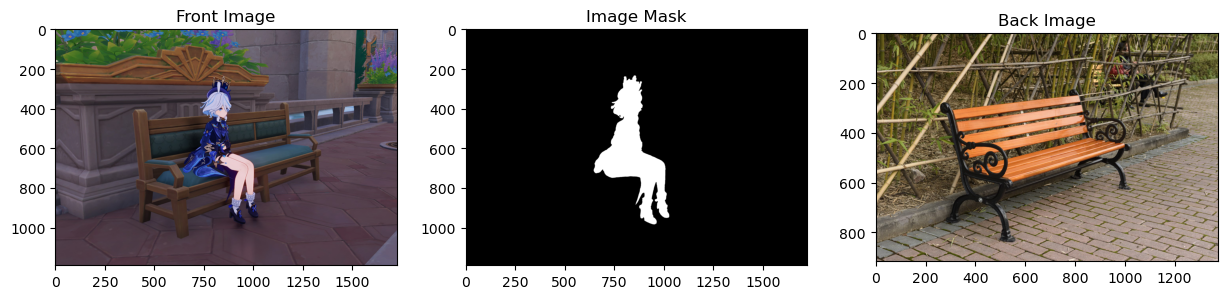

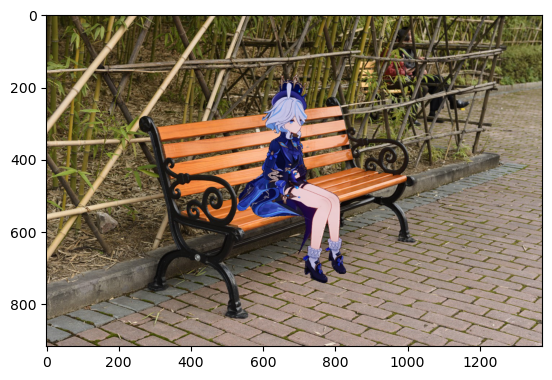

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

axes[0].imshow(front)
axes[0].set_title('Front Image')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Image Mask')

axes[2].imshow(back)
axes[2].set_title('Back Image')

plt.show()
plt.imshow(result_img)

## 通过高斯模糊后的蒙版进行alpha混合

In [7]:
# 使用GaussianBlur平滑蒙版并归一化到[0,1]
smoothed_mask = cv2.GaussianBlur(mask_translate, (21, 21), 0)
alpha = smoothed_mask.astype(np.float32) / 255.0

# 将两个图像传输到float32，以便稍后进行计算
front_float = front_translate.astype(np.float32)
back_float = back.astype(np.float32)

# 对每个通道进行alpha混合
for c in range(0, 3):
    front_float[:,:,c] = front_float[:,:,c] * alpha
    back_float[:,:,c] = back_float[:,:,c] * (1.0 - alpha)

# 混合结果图像
blended = cv2.add(front_float, back_float)
blended_result = blended.astype(np.uint8)

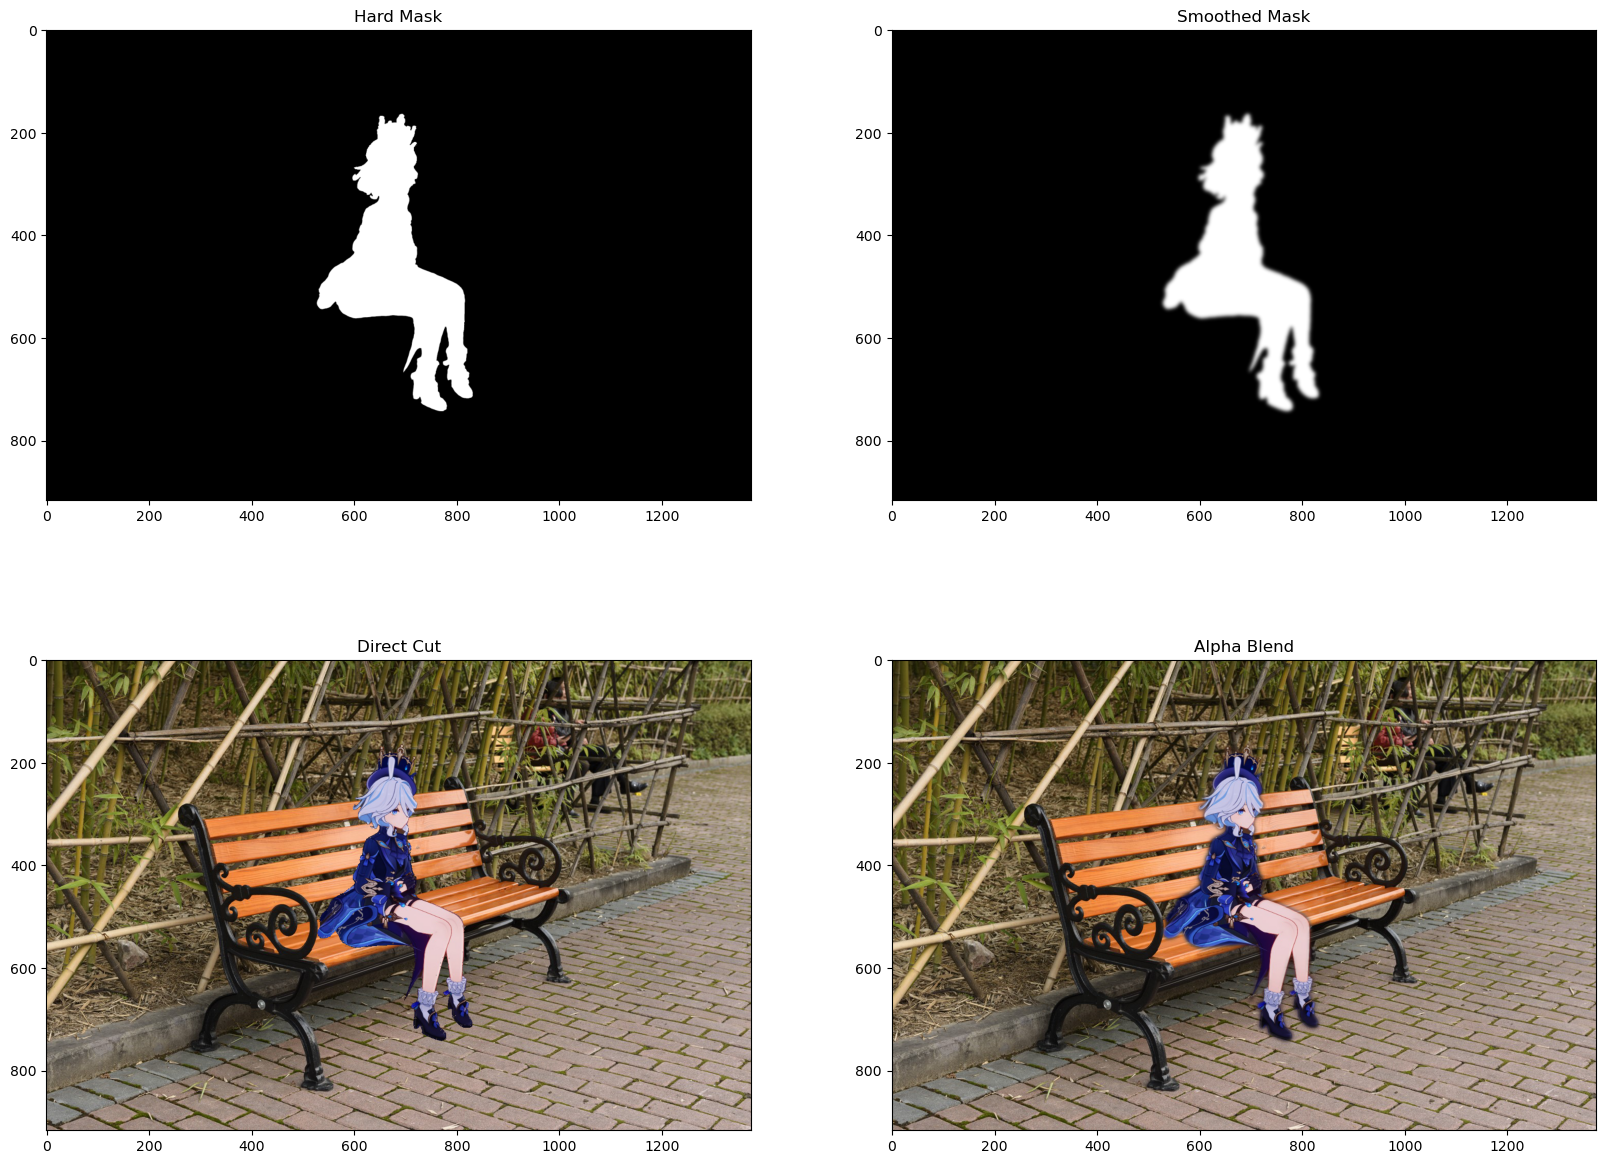

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

axes[0,0].imshow(mask_translate, cmap='gray')
axes[0,0].set_title('Hard Mask')

axes[0,1].imshow(smoothed_mask, cmap='gray')
axes[0,1].set_title('Smoothed Mask')

axes[1,0].imshow(result_img)
axes[1,0].set_title('Direct Cut')

axes[1,1].imshow(blended_result)
axes[1,1].set_title('Alpha Blend')

plt.show()

## 使用图像梯度混合

In [9]:
# 归一化蒙版
maskn = mask_translate.astype(np.float32) / 255.0

In [10]:
# 得到蒙版中的前图层的所有三个通道的梯度
front_gradient = []

for c in range(3):
    img = front_translate[:,:,c].astype(np.float32)
    [h,w] = img.shape
    im2ind = np.reshape(np.arange(0, h*w), [h,w])
    
    A = sparse.lil_matrix(((h-1)*(w-1)*2, h*w))
    b = np.zeros(((h-1)*(w-1)*2))
    e = 0
    for i in range(h):
        for j in range(w):
            if i < h-1 and maskn[i,j] > 0 and maskn[i+1,j] > 0:
                A[e, im2ind[i,j]] = 1
                A[e, im2ind[i+1,j]] = -1
                b[e] = np.float32(img[i,j]) - np.float32(img[i+1,j])
                e += 1
            if j < w-1 and maskn[i,j] > 0 and maskn[i,j+1] > 0:
                A[e, im2ind[i,j]] = 1
                A[e, im2ind[i,j+1]] = -1
                b[e] = np.float32(img[i,j]) - np.float32(img[i,j+1])
                e += 1
                
    v = sparse.linalg.lsqr(A, b, atol=1e-07, btol=1e-07)
    result_c = np.reshape(v[0], (h,w))
    front_gradient.append(result_c)

In [11]:
# 得到蒙面外的后图层的所有三个通道的梯度
back_gradient = []

for c in range(3):
    img = back[:,:,c].astype(np.float32)
    [h,w] = img.shape
    im2ind = np.reshape(np.arange(0, h*w), [h,w])
    
    A = sparse.lil_matrix(((h-1)*(w-1)*2, h*w))
    b = np.zeros(((h-1)*(w-1)*2))
    e = 0
    for i in range(h):
        for j in range(w):
            if i < h-1 and maskn[i,j] == 0 and maskn[i+1,j] == 0:
                A[e, im2ind[i,j]] = 1
                A[e, im2ind[i+1,j]] = -1
                b[e] = np.float32(img[i,j]) - np.float32(img[i+1,j])
                e += 1
            if j < w-1 and maskn[i,j] == 0 and maskn[i,j+1] == 0:
                A[e, im2ind[i,j]] = 1
                A[e, im2ind[i,j+1]] = -1
                b[e] = np.float32(img[i,j]) - np.float32(img[i,j+1])
                e += 1
                
    v = sparse.linalg.lsqr(A, b, atol=1e-07, btol=1e-07)
    result_c = np.reshape(v[0], (h,w))
    back_gradient.append(result_c)

In [12]:
# 相加两个蒙版后的梯度图像
all_gradient = []
for x in range(3):
    gradient = np.add(front_gradient[x],back_gradient[x])
    all_gradient.append(gradient)

[h,w] = all_gradient[c].shape
resultimg = np.zeros(back.shape)

# 获取梯度的梯度，并使用遮蒙版外的背面图像作为约束
for c in range(3):
    A = sparse.lil_matrix(((h)*(w)*3, h*w))
    b = np.zeros(((h)*(w)*3))
    e = 0

    for i in range(h):
        for j in range(w):
            if i < h-1:
                A[e, im2ind[i,j]] = 1
                A[e, im2ind[i+1,j]] = -1
                b[e] = np.float32(all_gradient[c][i,j]) - np.float32(all_gradient[c][i+1,j])
                e += 1
            if j < w-1:
                A[e, im2ind[i,j]] = 1
                A[e, im2ind[i,j+1]] = -1
                b[e] = np.float32(all_gradient[c][i,j]) - np.float32(all_gradient[c][i,j+1])
                e += 1
            if i < h-1 and j < w-1 and maskn[i,j] == 0:
                A[e, im2ind[i,j]] = 1
                b[e] = back[i,j,c]
                e += 1

    v = sparse.linalg.lsqr(A, b, atol=1e-07, btol=1e-07)
    result = np.reshape(v[0], (h,w))
    resultimg[:,:,c] = result
    
resultimg = np.clip(resultimg, 0, 255)
resultimg = resultimg.astype(np.uint8)

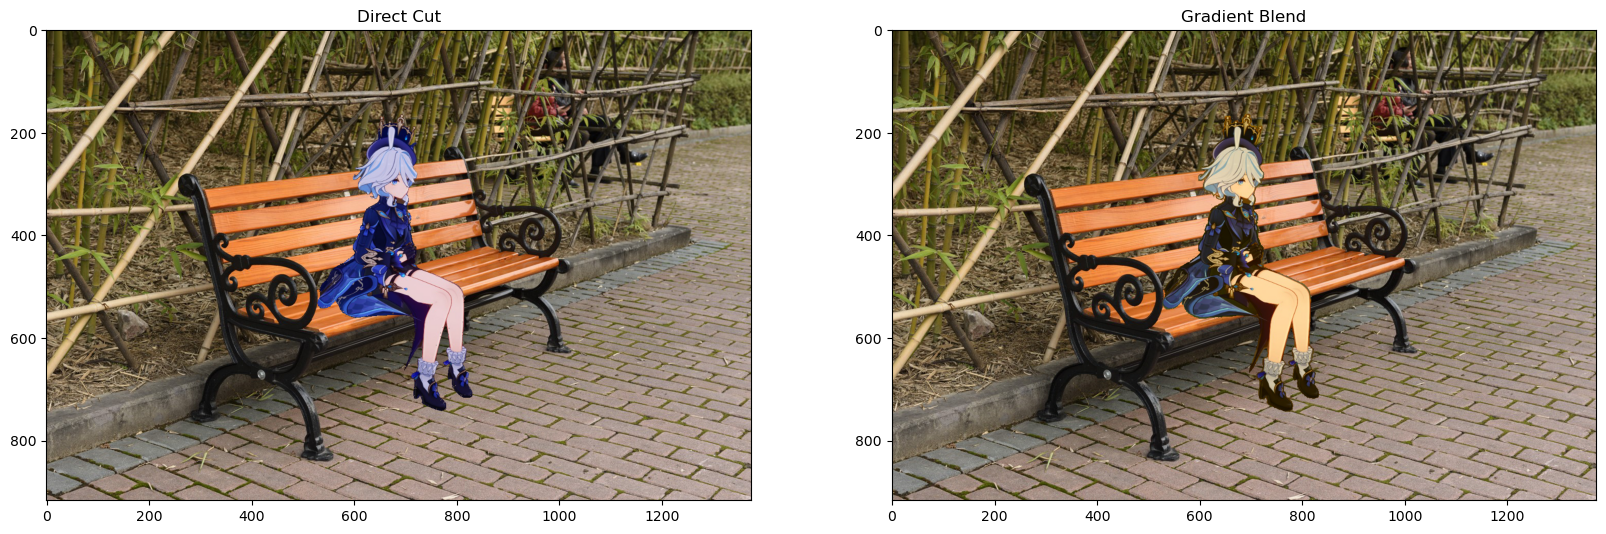

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

axes[0].imshow(result_img)
axes[0].set_title('Direct Cut')

axes[1].imshow(resultimg)
axes[1].set_title('Gradient Blend')

plt.show()

## 使用拉普拉斯金字塔混合

In [14]:
# 建立高斯金字塔
def gaussian_pyramid(image, levels):
    gp = [image]
    for _ in range(1, levels):
        image = cv2.pyrDown(image)
        gp.append(image)
    return gp

# 在高斯金字塔的基础上建立拉普拉斯金字塔
def laplacian_pyramid(gp):
    lp = [gp[-1]]
    for i in range(len(gp)-1, 0, -1):
        size = (gp[i-1].shape[1], gp[i-1].shape[0])
        upsampled = cv2.pyrUp(gp[i], dstsize=size)
        lp.append(np.subtract(gp[i-1], upsampled))
    lp.reverse()
    return lp

In [15]:
#预处理图像，将所有数据改为float32
nmask_float = mask_translate.astype(np.float32) / 255.0
mask_3c = np.repeat(nmask_float[:,:,np.newaxis],3,axis=2)
front_f = front_translate.astype(np.float32)
back_f = back.astype(np.float32)

index = 6

# 前图层的高斯和拉普拉斯金字塔
gp_front = gaussian_pyramid(front_f, index)
lp_front = laplacian_pyramid(gp_front)

# 后图层的高斯和拉普拉斯金字塔
gp_back = gaussian_pyramid(back_f, index)
lp_back = laplacian_pyramid(gp_back)

# 蒙版的高斯金字塔
gp_mask = gaussian_pyramid(mask_3c, index)

In [16]:
# 混合拉普拉斯金字塔的每一层
lp_list = []
for f, b, m in zip(lp_front, lp_back, gp_mask):
    lp_list.append(f * m + b * (1.0 - m))

# 通过对每一层的拉普拉斯金字塔图进行上采样并叠加到下一层，递归重建图像
py_result = lp_list[index-1]
for i in range(1,index):
    up = cv2.pyrUp(py_result)
    if up.shape != lp_list[index-1-i].shape:
        up = cv2.resize(up, (lp_list[index-1-i].shape[1], lp_list[index-1-i].shape[0]))
    py_result = up + lp_list[index-1-i]

py_result = np.clip(py_result, 0, 255)
py_result = py_result.astype(np.uint8)

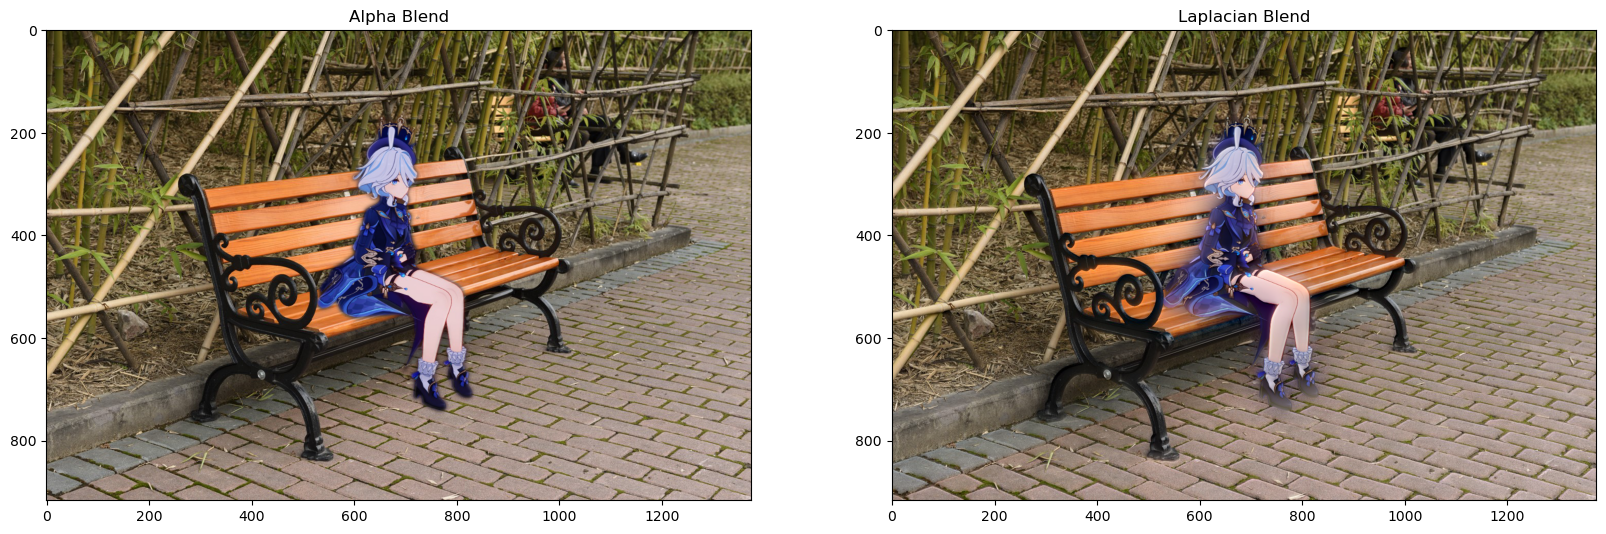

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

axes[0].imshow(blended_result)
axes[0].set_title('Alpha Blend')

axes[1].imshow(py_result)
axes[1].set_title('Laplacian Blend')

plt.show()